### Part 1 - Gibbs sampling
The conditional distribution of $Z_{ij}$ given $Z_{-ij}$ is simply the joint distribution divided by the marginal distribution $Z_{-ij}$. 

\begin{align}
p(Z_{ij}=1\ |\ Z_{-ij}) & = \frac{p(Z_{ij}=1,Z_{-ij})}{\sum_{d \in \{-1,+1\}}{p(Z_{ij}=d,Z_{-ij})}} 
\end{align}

Since the probability density shows Markov Field property, we can write

\begin{align}
p(Z_{ij}=1\ |\ Z_{-ij}) & = \frac{p(Z_{ij}=1,Z_{kl})}{\sum_{d \in \{-1,+1\}}{p(Z_{ij}=d,Z_{kl})}} \\
& = \frac{p(Z_{ij}=1,Z_{kl})}{p(Z_{ij}=1,Z_{kl})+p(Z_{ij}=-1,Z_{kl})} 
\end{align}

where $Z_{kl}$ are the neighbours of $Z_{ij}$. The above expression is proportional to 

\begin{align}
p(Z_{ij}=1\ |\ Z_{-ij}) & \propto \frac{\text{exp}\big(\beta \times 1\times \sum_{(k,l)}{Z_{kl}}\big)}{\text{exp}\big(\beta \times 1\times \sum_{(k,l)}{Z_{kl}}\big)+\text{exp}\big(\beta \times -1 \times \sum_{(k,l)}{Z_{kl}}\big)}
\end{align}

If we let $s_{ij} = \sum_{(k,l)}{Z_{kl}} $ and doing some algebraic manupulation, the conditional probability can be sampled from the distribution shown below.

\begin{align}
p(Z_{ij}=1\ |\ Z_{-ij}) & \propto \frac{1}{1 + \text{exp}(-2\beta s_{ij})}
\end{align}




The function below calculates $ s $ which consists of sums of each pixels' neighbours over entire image, by making use of circular shift function for 2D arrays.

In [1]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

def sumNeighbours(img):
    return np.roll(img, -1, axis=0) + \
           np.roll(img,  1, axis=0) + \
           np.roll(img, -1, axis=1) + \
           np.roll(img,  1, axis=1)    

A Gibbs sampler function takes size of the image to be generated, number of iterations and $\beta$ as input arguments. It evaluates the Bernoulli sampling using uniform number generator. If $\gamma$ is set to 0, the function will draw Gibbs samples. \\
Here, instead of iterating over all pixels one by one (in two for loops), I decided to use two masks, and sample according to $p(M_{1}( Z^{(n)}_{1})\ |\ M_{2}( Z^{(n-1)}))$ and $p(M_{2}(Z_{2}^{(n)})\ |\ M_{1}(Z^{(n-1)}))$ on each iteration $n$. Here, $M_{1}$ and $M_{2}$ are complementary masks over the image, consisting of 1's and 0's, such that it looks like
$$ M_{1}=
  \left[ {\begin{array}{cccc}
   1 & 0 & 1 & ... \\
   0 & 1 & 0 & ... \\
   1 & 0 & 1 & ... \\
   ...&...&...&...
     \end{array} } \right] $$ 
and $M_{2}$ is just the complement. This way, the entire image is drawn in two steps, first for pixels covered by $M_{1}$ then for their neighbouring pixels. 

In [2]:
def gibbsSampler(X, n_iter, gamma, beta):
    # initialize Z0
    Z = np.sign(0.5 - np.random.rand(X.shape[0],X.shape[1]))
    # mask 1
    m1 = np.reshape(np.arange(X.shape[0]*X.shape[1]),Z.shape)
    m1 = np.mod(m1,2) == 0
    m1 = m1.astype(np.int)
    # mask 2
    m2 = np.ones(m1.shape) - m1
    masks = [m1,m2]

    for n in range(n_iter):
        th=np.random.rand(X.shape[0],X.shape[1])
        for m in range(2):
            temp = np.zeros(Z.shape)
            s = sumNeighbours(Z)        
            prob = 1./(1+np.exp(-2*(gamma*X + beta*s)))
            temp[prob>th] = 1
            temp[prob<=th] = -1
            Z = masks[m]*temp + masks[np.mod(m+1,2)]*Z
    return Z                         


Then samples for different $\beta$ values are generated. I picked iteration number as 5, since it gave similar results to requested images in Assignment sheet. 

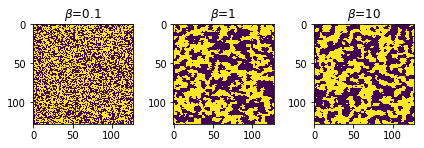

In [3]:
# initialize parameters
n_iter = 5
betas = [.1,1,10]
fig=plt.figure()
for beta in betas :
    Z = gibbsSampler(np.ones([128,128]),n_iter,0,beta)
    ax=fig.add_subplot(1,len(betas),betas.index(beta)+1)        
    ax.imshow(Z)
    ax.set_title(r'$\beta$'+ '=' +str(beta))
    
plt.tight_layout()
plt.show()

### Part 2 - Gibbs Denoiser
The derivation is quite similar, except this time it follows from $p(Z_{ij}=1\ |\ Z_{-ij},X) = p(Z_{ij}=1\ |\ Z_{-kl},X_{ij}) $, and yields 

\begin{align}
p(Z_{ij}=1\ |\ Z_{-ij},X) & \propto \frac{1}{1 + \text{exp}\big(-2\ (\beta s_{ij} + \gamma X_{ij})\big)}
\end{align}

The same Gibbs sampler is used as before and results for varying $\beta$ and $\gamma$ values are plotted as shown below.

/home/korhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


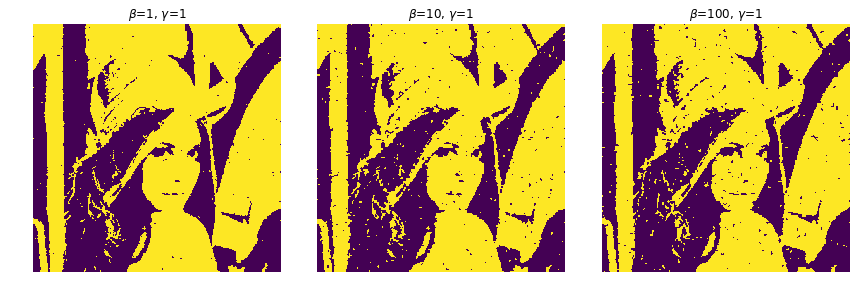

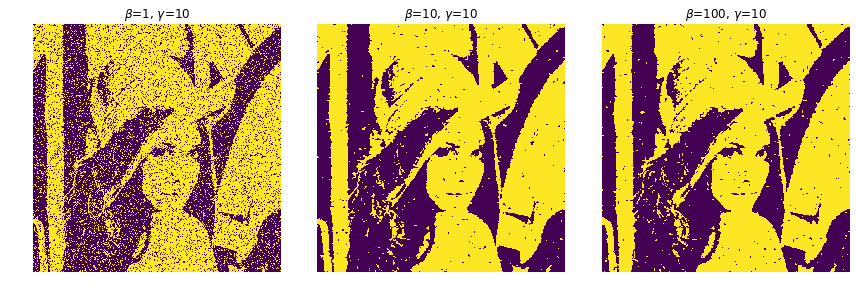

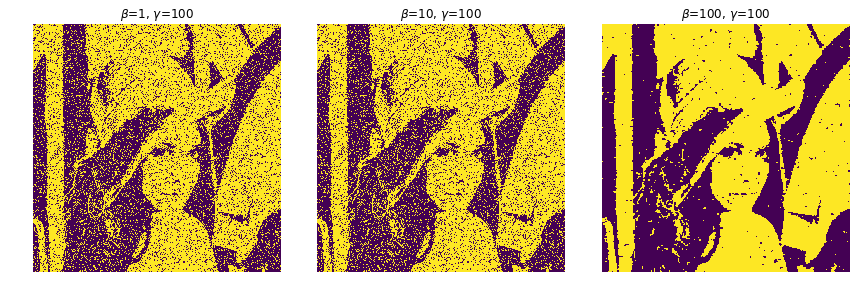

In [4]:
img = misc.imread('image/lena.pgm')
X = 2 * (img > 127) - 1

# initialize parameters
n_iter = 10
betas = [1,10,100]
gammas = [1,10,100]


for gamma in gammas:
    fig=plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(12)
    for beta in betas :
        Z = gibbsSampler(X,n_iter,gamma,beta)
        ax=fig.add_subplot(1,len(betas),betas.index(beta)+1)        
        ax.imshow(Z)
        ax.set_title(r'$\beta$'+ '=' +str(beta) + ', ' + r'$\gamma$' + '=' + str(gamma))
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    


Increasing $\beta$ increases the importance of coherent neighbours (Ising model) and increasing $\gamma$ increases the dependence on noisy image. 